In [13]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.dates import DayLocator, DateFormatter
from utils.extraploation_class import Extrapolation
from utils.calculateConsumption import calculateConsumption, getConsumptionYear
from utils.read_CSV import *
from utils.calcDifference import differenceBetweenDataframes, StorageIntegration


In [14]:
# Verbrauch pro Woche in ein Dataframe speichern
consumption_development_rate = 1.045
selectedYear = "2030"
selectedWeek = "30"
consumption_df = calculateConsumption(consumption_development_rate)

# daten nur für angegebene woche und jahr finden
week_filtered_data_consumption = consumption_df[
    (consumption_df['Year'] == selectedYear) & 
    (consumption_df['Week'] == selectedWeek)
]

# dataframe erstellen nur mit datum und gesamtverbrauch
week_consumption_df = week_filtered_data_consumption[['Datum', 'Gesamtverbrauch']]
week_consumption_df['Datum'] = pd.to_datetime(week_consumption_df['Datum'])

print(consumption_df)
print (week_consumption_df)

Data für 2023 loaded succsessfully.
                    Datum  Gesamtverbrauch      Time Month Year Month  \
0     2030-01-01 00:00:00     13163.616486  00:00:00   Jan    2030 01   
1     2030-01-01 00:15:00     13055.427971  00:15:00   Jan    2030 01   
2     2030-01-01 00:30:00     13012.560823  00:30:00   Jan    2030 01   
3     2030-01-01 00:45:00     12952.002471  00:45:00   Jan    2030 01   
4     2030-01-01 01:00:00     12837.349862  01:00:00   Jan    2030 01   
...                   ...              ...       ...   ...        ...   
35035 2030-12-31 22:45:00     14671.111179  22:45:00   Dec    2030 12   
35036 2030-12-31 23:00:00     14632.326617  23:00:00   Dec    2030 12   
35037 2030-12-31 23:15:00     14432.620143  23:15:00   Dec    2030 12   
35038 2030-12-31 23:30:00     14281.224264  23:30:00   Dec    2030 12   
35039 2030-12-31 23:45:00     14000.546512  23:45:00   Dec    2030 12   

      Year Month Day Day  Year Weekday Week  
0         2030 01 01  01  2030       2   

C:\Users\jmend\AppData\Local\Temp\ipykernel_34804\3487769508.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_consumption_df['Datum'] = pd.to_datetime(week_consumption_df['Datum'])


In [17]:
# Erzeugung PV, Onshore, Offshore-Wind in Dataframe speichern

#directory_yearly_generation
production_df = getData("Erzeugung")

# Daten extrapolieren 2024 bis 2030
for year in range(2024,2031):
    prev_year_df =production_df.get(year-1).copy()    #Kopie des Dataframe des letzten Jahres
    extrapolated_data = Extrapolation(prev_year_df, year, 1.129, 1.066, 1.131, None)        #Erstellung eines neuen Objekts, mit einem DataFrame
    production_df[extrapolated_data.year]= extrapolated_data.df   #DataFrame in das Erzeugungsverzeichnis gespeichert wird

prod_df_2030 = production_df.get(2030)

# Überprüfe, ob die Spalten vorhanden sind
required_columns = ['Wind Offshore', 'Wind Onshore', 'Photovoltaik']
if all(column in prod_df_2030.columns for column in required_columns):
    # Berechne die Summe der gewünschten Spalten für jede 15-Minuten-Periode
    prod_df_2030['Gesamterzeugung_EE'] = prod_df_2030[required_columns].sum(axis=1)
    
    # Speichere die Ergebnisse in production_2030
    production_2030 = prod_df_2030[['Datum', 'Gesamterzeugung_EE']]


yearly_generation = pd.DataFrame.from_dict(production_df.get(int(selectedYear)))
required_columns = ['Wind Offshore', 'Wind Onshore', 'Photovoltaik']

yearly_generation['EE_Gesamt'] = yearly_generation[required_columns].sum(axis=1)


week_filtered_data_production = yearly_generation[
    (yearly_generation['Week'] == selectedWeek)
]

week_production_df = week_filtered_data_production[['Datum', 'EE_Gesamt']]
week_consumption_df['Datum'] = pd.to_datetime(week_consumption_df['Datum'])

# Speicherintegration
resdidual_df = differenceBetweenDataframes(consumption_df, production_2030)
storage_df = addTimeInformation(StorageIntegration(resdidual_df, 2000, 1000))

week_filtered_data_storage = storage_df[
    (storage_df['Year'] == selectedYear) & 
    (storage_df['Week'] == selectedWeek)
]

# dataframe erstellen nur mit datum und gesamtverbrauch
week_storage_df = week_filtered_data_storage[['Datum', 'Speicher']]
week_storage_df['Datum'] = pd.to_datetime(week_storage_df['Datum'])

# Merge the dataframes on 'Datum' column
Storage_EE = pd.merge(production_2030[['Datum', 'Gesamterzeugung_EE']], storage_df[['Datum', 'Speicher']], on='Datum')

# Add the relevant columns
Storage_EE['Total_EE'] = Storage_EE['Gesamterzeugung_EE'] + Storage_EE['Speicher']
# Add the 'Speicher' column from storage_df and 'Gesamterzeugung_EE' column from production_2030
combined_df = pd.merge(production_2030[['Datum', 'Gesamterzeugung_EE']], storage_df[['Datum', 'Speicher', 'Week', 'Year']], on='Datum')
combined_df['Erzeugung&Speicher'] = combined_df['Gesamterzeugung_EE'] + combined_df['Speicher']

# Create the new dataframe with the required columns
storage_ee_df = combined_df[['Datum', 'Erzeugung&Speicher', 'Week', 'Year']]

week_filtered_data_storage_ee = storage_ee_df[
    (storage_ee_df['Year'] == selectedYear) & 
    (storage_ee_df['Week'] == selectedWeek)
]

# dataframe erstellen nur mit datum und gesamtverbrauch
week_storage_ee_df = week_filtered_data_storage[['Datum', 'Erzeugung&Speicher']]
week_storage_ee_df['Datum'] = pd.to_datetime(week_storage_ee_df['Datum'])


Data für 2015 loaded succsessfully.
Data für 2016 loaded succsessfully.
Data für 2017 loaded succsessfully.
Data für 2018 loaded succsessfully.
Data für 2019 loaded succsessfully.
Data für 2020 loaded succsessfully.
Data für 2021 loaded succsessfully.
Data für 2022 loaded succsessfully.
Data für 2023 loaded succsessfully.


C:\Users\jmend\AppData\Local\Temp\ipykernel_34804\2385508915.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_consumption_df['Datum'] = pd.to_datetime(week_consumption_df['Datum'])
c:\Users\jmend\OneDrive - HAW-HH\REE\IPJ1\SS-Programmieren\Klimaneutral-20245\utils\calcDifference.py:84: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-4615.157996135413' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  storage_df.loc[i, 'Netz'] = storage + diff
c:\Users\jmend\OneDrive - HAW-HH\REE\IPJ1\SS-Programmieren\Klimaneutral-20245\utils\calcDifference.py:74: FutureWarning: Setting an item of incompatible dtype is deprecated and wi

KeyError: "['Erzeugung&Speicher'] not in index"

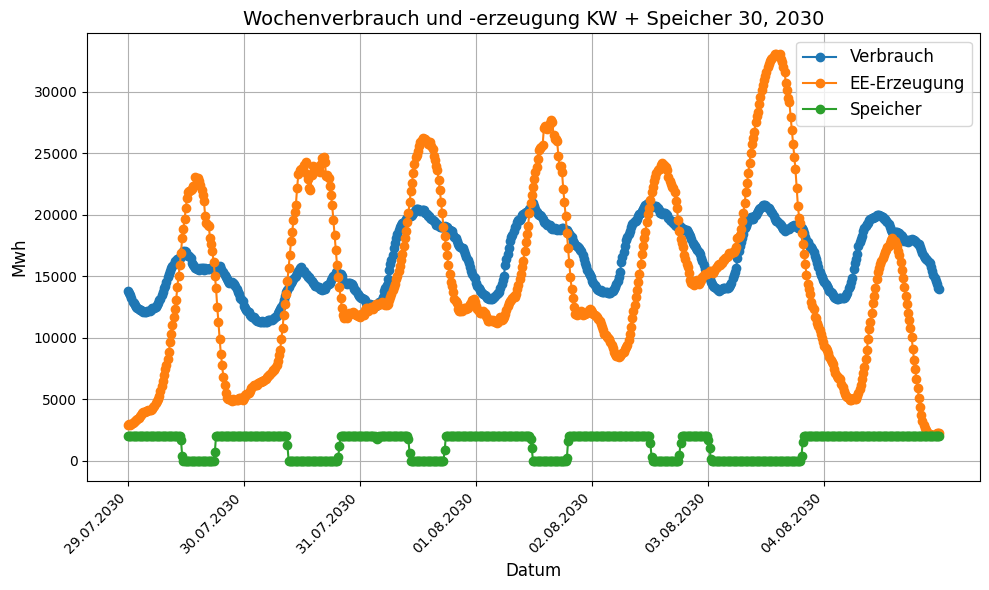

In [ ]:
def create_week_comparison(year, week, consumption_data, production_data, storage_data, storage_ee_data)
    
    # Assuming your dataframes have columns 'Date' and 'Energy'
    plt.figure(figsize=(10, 6))

    # Plot consumption
    plt.plot(consumption_data['Datum'], consumption_data['Gesamtverbrauch'], label='Verbrauch', marker='o')

    # Plot production
    plt.plot(production_data['Datum'], production_data['EE_Gesamt'], label='EE-Erzeugung', marker='o')

    # Plot storage
    plt.plot(storage_data['Datum'], storage_data['Speicher'], label='Speicher', marker='o')

    # Plot storage plus ee
    plt.plot(storage_ee_data['Datum'], storage_ee_data['Erzeugung&Speicher'], label='Speicher + EE', marker='o')
    
     # Customize x-axis to show one tick per day
    unique_dates = consumption_data['Datum'].dt.normalize().unique()  # Get unique dates (one per day)
    plt.gca().set_xticks(unique_dates)  # Set ticks to these dates
    formatted_labels = [date.strftime('%d.%m.%Y') for date in unique_dates]  # Format labels
    plt.gca().set_xticklabels(formatted_labels, rotation=45, ha='right')  # Set labels and rotate


    # Adding labels and title
    plt.xlabel('Datum', fontsize=12)
    plt.ylabel('Mwh', fontsize=12)
    plt.title(f'Wochenverbrauch und -erzeugung KW + Speicher {week}, {year}', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()


create_week_comparison(selectedYear, selectedWeek, week_consumption_df, week_production_df, week_storage_df, week_storage_ee_df)